# Embedded Topic Model (ETM)

In [1]:
import string
import json
from octis.preprocessing.preprocessing import Preprocessing
from octis.models.ETM import ETM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Integer
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [ ]:

frac = 0.001
data_path = 'data/input'
corpus_path = 'data/input/corpus.txt'
label_path = 'data/input/labels.txt'
vocab_path = 'data/processed/dataset/vocabulary.txt'
proc_path = 'data/processed/dataset'
#embeddings_path = 'data/embeddings_small/embeddings.pkl'
#model_path = 'model'


num_iters = 50
number_of_calls = None # Depends on size of search space

In [4]:
from utils.embeddings import *
from preprocessing.clean_text import *

c:\Users\marta\miniconda3\envs\OCTIS\lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 8.0.0. Please consider upgrading.
  warnings.warn(


## Data setup

In [5]:
extract_corpus_and_labels_from_songs_csv(csv_input_path = 'data/raw/cleaned_train_lyrics.csv' , zip_input_path='data/raw/lyrics.zip', output_path = data_path,frac=frac) 

Corpus has been saved to data/input\corpus.txt
Labels have been saved to data/input\labels.txt


## Preprocessing


In [6]:
preprocessor = Preprocessing(lowercase=True,
                             min_df = 10,
                             max_df = 0.85,
                             remove_punctuation=True,
                             punctuation=string.punctuation,
                             remove_numbers=True,
                             lemmatize= True,
                             stopword_list=CUSTOM_STOPWORDS,
                             min_chars=3,
                             min_words_docs=10,
                             language='english',
                             split=True,
                             verbose=True)

In [8]:

# Checks if dataset folder exists in processed, if not it processes the dataset. Otherwise it loads it
if not os.path.exists(proc_path):
    dataset = preprocessor.preprocess_dataset(documents_path = corpus_path,labels_path = label_path)
    dataset.save(proc_path)
else:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(proc_path)

100%|██████████| 500/500 [00:34<00:00, 14.44it/s]


created vocab
730
words filtering done


In [9]:
dataset.get_metadata()

{'total_documents': 500,
 'vocabulary_length': 730,
 'preprocessing-info': ['lowercase',
  'remove_punctuation',
  'lemmatize',
  'filter words with document frequency lower than 10 and higher than 0.85',
  'filter words with less than 3 character',
  'filter documents with less than 10 words'],
 'last-training-doc': 347,
 'last-validation-doc': 422}

## Embeddings loading

In [ ]:
# embeddings = extract_relevant_embeddings(vocab_path = vocab_path,
#                                          model_path= model_path,
#                                          output_dir= embeddings_path,
#                                          verbose= True)

Loaded 34731 words from data/processed/dataset/vocabulary.txt
Loaded embeddings from model/cc.en.300.vec/cc.en.300.vec


100%|██████████| 34731/34731 [00:03<00:00, 10633.53it/s]


Found 32384 relevant embeddings
Saving relevant embeddings to data/embeddings_small/embeddings.pkl/embeddings.pkl
Saved relevant embeddings to data/embeddings_small/embeddings.pkl/embeddings.pkl


## ETM model without optimization

In [ ]:
N_TOPICS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

current_device = torch.cuda.current_device()

print(f"Currently using GPU: {current_device}")
print(f"GPU Name: {torch.cuda.get_device_name(current_device)}")

In [14]:
model = ETM(num_topics= N_TOPICS,  
        num_epochs=100, 
        t_hidden_size=200, 
        rho_size=300, 
        embedding_size=300,
        activation='relu', 
        dropout=0.5, 
        lr=0.005, 
        optimizer='adam', 
        batch_size=64, 
        clip=0.0, 
        wdecay=1.2e-6, 
        bow_norm=1, 
        device=device, 
        train_embeddings= True, 
        embeddings_path= 'data/embeddings/embeddings.pkl',
        embeddings_type='pickle', 
        use_partitions=True)
            

In [15]:
td, ch = TopicDiversity(topk=10), Coherence(texts = dataset.get_corpus(), topk=10, measure = 'c_npmi') # Initialize metric

In [ ]:
coherence_list_no_opt, topic_diversity_list_no_opt, iters = [], [], num_iters

for i in tqdm(range(num_iters)):
  output = model.train_model(dataset)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))


print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))


  0%|          | 0/1 [00:00<?, ?it/s]

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=730, bias=False)
  (alphas): Linear(in_features=300, out_features=10, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=730, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=200, out_features=10, bias=True)
  (logsigma_q_theta): Linear(in_features=200, out_features=10, bias=True)
)
****************************************************************************************************
Epoch----->1 .. LR: 0.005 .. KL_theta: 0.01 .. Rec_loss: 871.01 .. NELBO: 871.02
****************************************************************************************************
****************************************************************************************************
VALIDATION .. LR: 0.005 .. KL_theta: 0.0 .. Rec_loss: 305.14 .. NELBO: 305.14
*****

100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

Mean coherence:  -0.007522921011599505 
Mean topic diversity:  0.12


In [17]:
model = ETM()

In [18]:
# Optimization for hyperparameters based on coherence (to be substituted with a combination of ch e td ?)


# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "t_hidden_size": Integer(low= 50, high=300),
                "lr": Real(low=1e-4, high=1e-1)}

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

if(number_of_calls == None):
    number_of_calls = len(search_space.keys())*5


print(number_of_calls)

15


In [19]:
# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call=number_of_calls, # number of optimization iterations: rule of thumb 15*num_hyperparameters but takes a lot of time so 30 instead
                            model_runs=5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = [td],
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123,
                            save_models = True,
                            topk=20)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

results = json.load(open("results/test_LDA/result.json",'r'))

Current call:  0
model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=730, bias=False)
  (alphas): Linear(in_features=300, out_features=32, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=730, out_features=109, bias=True)
    (1): ReLU()
    (2): Linear(in_features=109, out_features=109, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=109, out_features=32, bias=True)
  (logsigma_q_theta): Linear(in_features=109, out_features=32, bias=True)
)
****************************************************************************************************
Epoch----->1 .. LR: 0.072830206116332 .. KL_theta: 2.3 .. Rec_loss: 846.5 .. NELBO: 848.8
****************************************************************************************************
****************************************************************************************************
VALIDATION .. LR: 0.072830206116332 .. KL_theta: 0.02 .. 

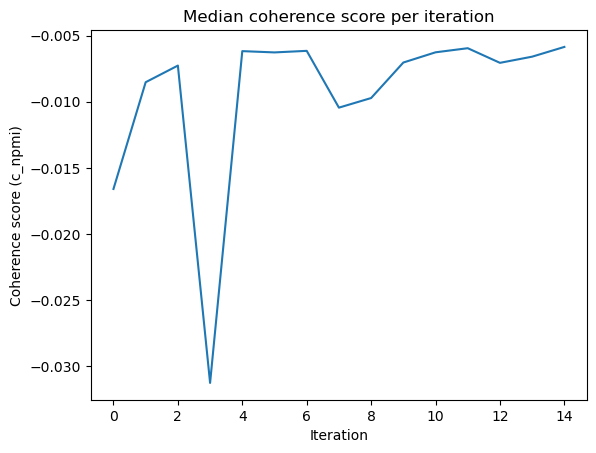

In [20]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_npmi)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.show()

In [21]:
max_index = results["f_val"].index(max(results["f_val"]))
print(results["f_val"][max_index])


-0.005854300136059619


In [22]:
print(results["x_iters"].keys())

num_topics = results["x_iters"]["num_topics"][max_index]
t_hidden_size = results["x_iters"]["t_hidden_size"][max_index]
lr = results["x_iters"]["lr"][max_index]

print("Optimal number of topics: ", num_topics)
print("Optimal encoder hidden size: ", t_hidden_size)
print("Optimal learning rate: ", lr)

dict_keys(['lr', 'num_topics', 't_hidden_size'])
Optimal number of topics:  17
Optimal encoder hidden size:  210
Optimal learning rate:  0.0003277413579898397


In [25]:
model = ETM(num_topics= num_topics,  
        num_epochs=100, 
        t_hidden_size=t_hidden_size, 
        rho_size=300, 
        embedding_size=300,
        activation='relu', 
        dropout=0.5, 
        lr=lr, 
        optimizer='adam', 
        batch_size=64, 
        clip=0.0, 
        wdecay=1.2e-6, 
        bow_norm=1, 
        device=device, 
        train_embeddings=True, 
        embeddings_path= 'data/embeddings/embeddings.pkl',
        embeddings_type='pickle', 
        use_partitions=True)

In [ ]:
coherence_list, topic_diversity_list, iters = [], [], num_iters

for i in range(num_iters):
  output = model.train_model(dataset, top_words=20)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))



print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

model: ETM(
  (t_drop): Dropout(p=0.5, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=730, bias=False)
  (alphas): Linear(in_features=300, out_features=17, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=730, out_features=210, bias=True)
    (1): ReLU()
    (2): Linear(in_features=210, out_features=210, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=210, out_features=17, bias=True)
  (logsigma_q_theta): Linear(in_features=210, out_features=17, bias=True)
)
****************************************************************************************************
Epoch----->1 .. LR: 0.0003277413579898397 .. KL_theta: 0.03 .. Rec_loss: 878.29 .. NELBO: 878.32
****************************************************************************************************
****************************************************************************************************
VALIDATION .. LR: 0.0003277413579898397 .. KL_theta: 0.01 .. Rec_lo

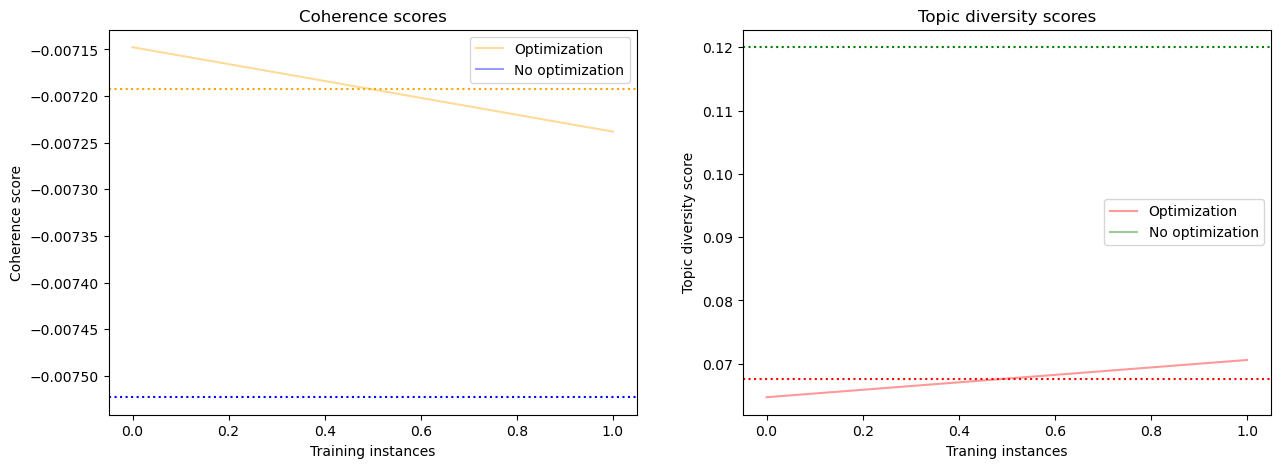

In [30]:

# Plot of the coherences of the models (no opt vs opt) and the topic diversity of the models (no opt vs opt). Both plots also show the mean values and the variance!
# Two plots side by side 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Coherence scores plot
axs[0].plot(coherence_list, label="Optimization", color = 'orange', alpha = 0.4)
axs[0].plot(coherence_list_no_opt, label="No optimization", color = 'blue', alpha = 0.4)
axs[0].axhline(y=np.mean(coherence_list), color='orange', linestyle=':')
axs[0].axhline(y=np.mean(coherence_list_no_opt), color='blue', linestyle=':')
axs[0].set_title("Coherence scores")
axs[0].set_xlabel("Training instances")
axs[0].set_ylabel("Coherence score")
axs[0].legend()

# Topic diversity scores plot
axs[1].plot(topic_diversity_list, label="Optimization", color = 'r', alpha = 0.4)
axs[1].plot(topic_diversity_list_no_opt, label="No optimization", color = 'g', alpha = 0.4)
axs[1].axhline(y=np.mean(topic_diversity_list), color='r', linestyle=':')
axs[1].axhline(y=np.mean(topic_diversity_list_no_opt), color='g', linestyle=':')
axs[1].set_title("Topic diversity scores")
axs[1].set_xlabel("Traning instances")
axs[1].set_ylabel("Topic diversity score")
axs[1].legend()

plt.show()